
<img src="../images/01_Customer_Conversion_Rate.png" alt="Drawing" style="width: 750px;"/>

---

# Description

For this challenge, data includes info about users who visited the Acme website; whether they converted to a sale or not as well as some of their characteristics including: country, marketing channel, age, whether or not they are a new user, and the number of pages visited during that session (as a proxy for site activity/time spent on site).

The goals for this project are to:

  * Predict customer conversion rate
  * Come up with recommendations for the product team and the marketing team to improve conversion rate

In [2]:
from itertools import combinations

from matplotlib import rcParams
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import seaborn as sns

from scipy.stats import spearmanr

from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import scale

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sns.set_style('darkgrid')
sns.set(font_scale=1.25)

---
# 1. Look at the Big Picture
---

### 1.1 Problem Description

Welcome to Acme Machine Learning!  The first task you are asked to perform is to build a model to predict customer conversion on the Acme website using the customer conversion dataset. This data has metrics such as whether or not a session resulted in a sale (converted) as well as some of the user characteristics including: country, marketing channel, age, whether or not they are a new user, and the number of pages visited during that session (as a proxy for site activity/time spent on site) for each session a user logged in. Our model should learn from this data and be able to classify weather or not a session will convert to a sale or not.

Your boss tells you that model predictions will be used to come up with recommendations for the product and marketing teams to improve conversion rate. Currently there is no solution/workaround to inform the product and marketing teams, which is why Acme thinks it would be useful to train a model to classify users and potentially learn by interpreting the model. The Acme conversion data looks like a great dataset to exploit for this purpose, since it includes user metrics as well as weather or not they were converted.

With this information, we should be able to frame the problem by answering the following:
* **Supervised, unsupervised, or reinforcement learning?**
  * **Supervised learning**, since we are given labeled training data (each session observation comes with the category; i.e., converted or not).

* **Classification, regression, or something else?**
  * **Binary classification**, since we only have two labels (1 for converted else 0).
  * Specifically, **Multivariate** binary classification since we have access to more than one feature in the dataset.

Let's think... **logistic regression** is a simple supervised multivariate binary-classification algotithm with high interpretability. Let's train and evaluate a multivariate logistic regression model for this purpose.

---

### 1.2 Performance Metric Selection

Before we get started, we must also decide how performance should be measured. For this tast, let's use precision, recall, and F-1 score, which are defined as follows:

Precision: $\quad \rm{P}=\dfrac{\rm{TP}}{\rm{TP}+\rm{FP}}$

Recall: $\quad \rm{R}=\dfrac{\rm{TP}}{\rm{TP}+\rm{FN}}$

F-1: $\quad \rm{F1}=\dfrac{2}{1/\rm{P} + 1/\rm{R}} = 2\left( \dfrac{\rm{P}\cdot\rm{R}}{\rm{P}+\rm{R}} \right) = \dfrac{\rm{TP}}{\rm{TP} + \frac{\rm{FN}+\rm{FP}}{2}}$ 

where $\rm{TP}$ denotes a true positive, $\rm{FP}$ denotes a false positive, and $\rm{FN}$ denotes a false negative. The F1 score is the *harmonic mean* of precision and recall and is sometimes a good way to compare two classifiers.

---

### 1.3 Model Assumptions

Logistic regression assumed the following:

  * Data is free of missing values
  * The predictant value is binary
  * All predictors are independent of each other

We will check these later on, but it is good to keep them in mind.

---
# 2 Get the data 
---

### 2.1 Load and Explore Data

Let's load in the data and take a look at the first 5 rows (sessions or observations):

In [4]:
df_obj = pd.read_csv('../data/conversion_data.csv')
df_obj.columns = ['country', 'age', 'new_user', 'source', 'pages_visited', 'converted']
df_obj.head()

,country,age,new_user,source,pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


Each row represents one user session. Each session has 6 attributes:
  * `country`
  * `age`
  * `new_user`
  * `source`
  * `pages_visited`
  * `converted`

The `DataFrame.info()` method can be helpful to get a quick breakdown of the data. Specifically, the `info()` method can show us the total number of rows (sessions), and each attribute’s type and number of NaN values:

In [5]:
df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country          316200 non-null object
age              316200 non-null int64
new_user         316200 non-null int64
source           316200 non-null object
pages_visited    316200 non-null int64
converted        316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


A few notes about the `info()` output:

  * There are 316,200 rows (sessions) in the dataset, which should be plenty to train and test our logistic regression model
  * Notice that **none of the rows (sessions) have missing values**
  * All attributes are of type `int` except for `country` and `source` features
  * The features `country` and `source` are of type `object`, meaning they can hold any kind of python object, but in this case, we know they are type `string`

When we looked at the top five rows, we can see that values in the `country` and `source` features were repetitive, indicating that they are most likely categorical features. We can find out how many categories exist and the percentage of rows (sessions) associated with each category by using the `value_counts(normalize=True)` method. Furthermore, we know that `new_user` and `converted` are also categorical with 0 denoting `False` and 1 denoting `True`.

In [6]:
df_obj['country'].value_counts(normalize=True)

US         0.563226
China      0.242258
UK         0.153226
Germany    0.041290
Name: country, dtype: float64

It looks like the `country` feature only has four categories: US, China, UK, and Germany. From this, we can see that most users visit our site from the US followed by China, UK, and Germany.

In [7]:
df_obj['source'].value_counts(normalize=True)

Seo       0.490323
Ads       0.280645
Direct    0.229032
Name: source, dtype: float64

The `source` feature only has three categories: Seo (Search Engine Optimization), Ads, and Direct. Again, we can see that Seo is the most common way users find the site followed by Ads and Direct. 

In [8]:
df_obj['new_user'].value_counts(normalize=True)

1    0.685465
0    0.314535
Name: new_user, dtype: float64

The `new_user` feature shows that nearly 70% of the sessions were by new users.

In [9]:
df_obj['converted'].value_counts(normalize=True)

0    0.967742
1    0.032258
Name: converted, dtype: float64

Conversion rate is around 3%. This is important to note because **we could achieve 97% accuracy by classifying `converted` as 0 every time.** We will keep this in mind when we begin to benchmark our model.

We can also use the `DataFrame.describe()` method to generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s non-categorical distributions, excluding NaN values. By default, the `describe()` method considers all numerical features. As a result, we will exclude `new_user`, `pages_visited`, and `converted` as we know they are categorical (see above):

In [10]:
df_obj.loc[:, ['age', 'pages_visited']].describe()

,age,pages_visited
count,316200.000000,316200.000000
mean,30.569858,4.872966
std,8.271802,3.341104
min,17.000000,1.000000
25%,24.000000,2.000000
50%,30.000000,4.000000
75%,36.000000,7.000000
max,123.000000,29.000000


### 2.2 Remove Outliers

There are a few things to note about these distributions:
  * Both of them have maximum values more than three standard deviations away from the mean:
    * `age`: max is 123 with 75% below 36
    * `pages_visited`: max is 29 with 75% below 7

Lets take a look at these distributions to determine if these are truely outlyers:

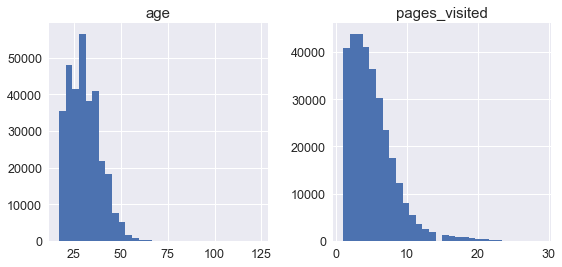

In [11]:
x = df_obj.loc[:,['age', 'pages_visited']].hist(figsize=(9, 4), bins=30);

Now we can see that both of the distributions have a tail that extends beyond three standard deviations of the mean (55 years and 14 pages). However, it is important to see how much data lies outside three standard deviations. Let's take a look:

In [12]:
print('Ages below 66 represent {0:.1f}% of observatons.'
      .format(len(df_obj[df_obj['age']<56]) / len(df_obj) * 100))
print('Users viewing less than 15 pages represent {0:.1f}% of observatons.'
      .format(len(df_obj[df_obj['pages_visited']<15]) / len(df_obj) * 100))

Ages below 66 represent 99.6% of observatons.
Users viewing less than 15 pages represent 98.2% of observatons.


It would appear that the ages greater than 55 are truely outliers, which makes sense because users were asked to enter age and this may have been entered incorrectly. On the other hand, it seems that nearly 2% of the observations contain people who viewed more than 14 pages. So let's leave that tail for now and see how the model performs.

In [13]:
df_obj = df_obj.query('age < 56')

---

# 3. Discover and visualize the data to gain insights

---

So far we have only taken a cursory look at the dataset in general. Next, let's dig a bit deeper by looking at the average conversion rate as a function of each feature:

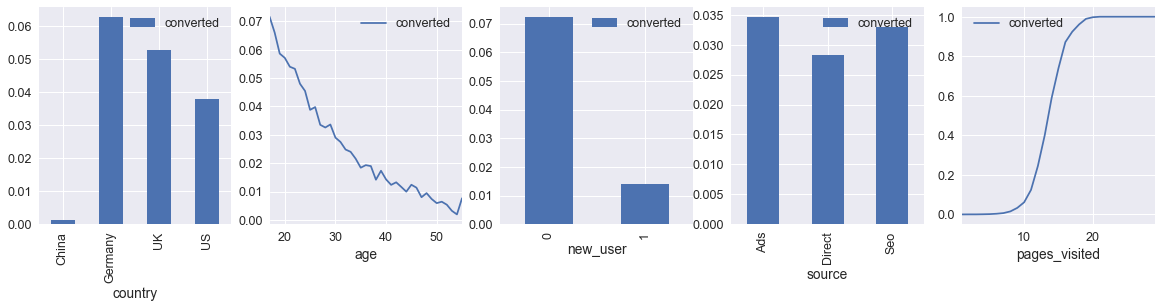

In [14]:
fig, ax = plt.subplots(figsize=(20, 4), ncols=5, nrows=1)
bars = {'country', 'new_user', 'source'}
for i, col in enumerate(['country', 'age', 'new_user', 'source', 'pages_visited']):
    if col in bars:
        df_obj.groupby(col).agg({'converted': 'mean'}).plot.bar(ax=ax[i]);
    else:
        df_obj.groupby(col).agg({'converted': 'mean'}).plot(ax=ax[i]);

Average conversion as a function of pages visited looks very much like a logistic function and it seems like we could come up with a decision boundary between 10 and 20.

Furthermore, `age` seems to show a negative correlation with conversion (on average) and the `country` and `new_user` fields also appear to have some descriminatory information in them. It seems like all of the features besides `source` would provide some predictive value to the model. So, let's prepare these features for machine learning in the next section.

Before we move on **it is important to create a testing set, set it aside, and never look at it!** Here we will use purely random sampling methods. This is generally fine if our dataset is large enough (especially relative to the number of attributes), which is true in our case

In [15]:
train_set, test_set = train_test_split(df_obj, test_size=0.2, random_state=42)
test_set.head()

,country,age,new_user,source,pages_visited,converted
208319,US,26,1,Seo,5,0
143073,US,32,1,Seo,3,0
276086,US,43,0,Direct,10,0
53447,US,29,1,Seo,5,0
177242,US,24,0,Seo,2,0


In [16]:
print(train_set.shape)
print(test_set.shape)

(252035, 6)
(63009, 6)


---
# 4. Prepare the data for Machine Learning algorithms
---

### 4.1 Feature Engineering

Most of our features seem like they are well suited for machine learning (i.e. numeric features of realtively simillar magnitue with no missing values) except for `country` which is still categorical text information. One simple way around this is to use one-hot encoding for country. This is easily achieved with the `pd.get_dummies()` method:

In [17]:
feat_list = ['pages_visited', 'age', 'new_user', 'is_China', 'is_Germany', 'is_UK', 'is_US']
feat_train_obj = pd.get_dummies(train_set, prefix='is').loc[:, feat_list]
feat_train_obj.head()

,pages_visited,age,new_user,is_China,is_Germany,is_UK,is_US
96783,4,36,1,0,0,0,1
27686,2,21,1,0,0,0,1
210492,8,45,1,0,0,1,0
255870,7,20,0,0,0,1,0
290561,1,25,1,0,0,0,1


Let's also isolate the labels while we are at it:

In [18]:
label_train_obj = train_set.loc[:, ['converted']]
label_train_obj.head()

,converted
96783,0
27686,0
210492,0
255870,0
290561,0


### 4.2 Feature Independance

The next step is to check for feature independence. We will use the Spearman R Coeccicient to look at independance between the ordinal features; i.e., age and pages visited.

In [19]:
spearmanr_coef, p_value = spearmanr(feat_train_obj['pages_visited'], feat_train_obj['age'])
print('pages visited, age:', '\n\tSpear Coeff:', spearmanr_coef, 'p_value:', p_value)

pages visited, age: 
	Spear Coeff: -0.0269825615085 p_value: 8.08895971752e-42


So, it looks like there these features are independent, which is good news!

Next, lets set aside out feature set for the first model, which will use only pages_visited or age as a univariate classification:

In [20]:
feat_train_pages = feat_train_obj.loc[:,['pages_visited']].values
feat_train_age = feat_train_obj.loc[:,['age']].values
label_train = label_train_obj['converted'].values

# 5. Select a model and train it

In [21]:
log_reg_pages = LogisticRegression()
log_reg_pages.fit(feat_train_pages, label_train);

log_reg_age = LogisticRegression()
log_reg_age.fit(feat_train_age, label_train);

Done! You now we a working Logistic Regression model. Let’s try it out and see how it performs:

In [22]:
print('log_reg_pages:\t', cross_val_score(log_reg_pages, feat_train_pages, label_train, cv=3, scoring="accuracy"))
print('log_reg_age:\t', cross_val_score(log_reg_age, feat_train_age, label_train, cv=3, scoring="accuracy"))

log_reg_pages:	 [ 0.98314526  0.98244298  0.98329981]
log_reg_age:	 [ 0.96744513  0.96744513  0.96744474]


Wow! The `pages_visited` model had over 98% accuracy (ratio of correct predictions) on all cross-validation folds. This looks amazing, doesn’t it? The `age` model didn't do quite as well with only 97% accuracy. Before we get too excited, let’s look at a naive classifier that classifies every user as "not-converted":

In [23]:
class NaiveClassifier(BaseEstimator):
    def fit(self, feat, label=None):
        pass
    def predict(self, feat):
        pred = np.zeros((len(feat), 1), dtype=bool)
        pred[0] = True;
        return pred

In [24]:
naive_clf = NaiveClassifier()
print('naive_classifier:\t', cross_val_score(naive_clf, feat_train_pages, label_train, cv=3, scoring="accuracy"))

naive_classifier:	 [ 0.96796886  0.96686188  0.96746855]


That’s right, it has nearly 97% accuracy! This is simply because only about 3% of users are actually converted, so if you always guess "not-converted", you will be right about 97% of the time.

**This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).** 
So, let's take a look at the precision and recall:

In [25]:
print(classification_report(label_train, naive_clf.predict(feat_train_pages)))

             precision    recall  f1-score   support

          0       0.97      1.00      0.98    243830
          1       0.00      0.00      0.00      8205

avg / total       0.94      0.97      0.95    252035



Again, we see the 97% precision at 100% recall for the naive classifier.

In [26]:
print(classification_report(label_train, log_reg_pages.predict(feat_train_pages)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    243830
          1       0.82      0.61      0.70      8205

avg / total       0.98      0.98      0.98    252035



Now our classifier does not look as shiny as it did when you looked at its accuracy. When it claims an customer was converted, it is correct only 82% of the time. Moreover, it only detects 61% of converted users.

Let's visualize the model:

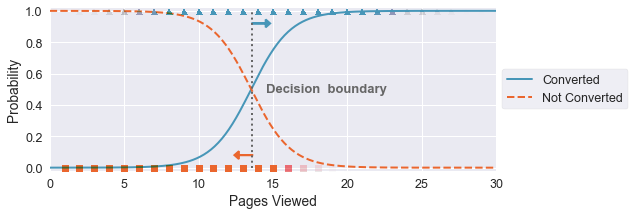

In [27]:
x0 = np.linspace(0, 30, 250).reshape(-1, 1)
label_proba = log_reg_pages.predict_proba(x0)
visualize_1d_logreg(x0, label_proba, ['Converted', 'Not Converted'], 0.002,
                    'Pages Viewed', feat_train_pages, label_train)

After chatting with the product and marketing teams, they decide that they would like to have a higer recall, so that they can detect users that are likely to be converted. They also said they are willing to deal with precition as low as 60%. So in order to do this, we will need to set the decision threshold at a location other than zero.

Scikit-Learn does not allow users to set the threshold directly. However, it does give users access to the decision scores that it uses to make predictions. Instead of calling the classifier’s `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, and then makes predictions based on those scores using any threshold you want:

In [28]:
label_scores = log_reg_pages.decision_function([[0], [5], [10], [15], [20]])
print(label_scores)

[-10.20132155  -6.43440767  -2.6674938    1.09942008   4.86633396]


So how can you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the `cross_val_predict()` function, but this time specifying that you want it to return decision scores instead of predictions:

In [29]:
label_scores = cross_val_predict(log_reg_pages, feat_train_pages, label_train, cv=3, method="decision_function")

Now with these scores you can compute precision and recall for all possible thresholds using the `precision_recall_curve()` function:

In [30]:
precisions, recalls, thresholds = precision_recall_curve(label_train, label_scores)

Finally, you can plot precision and recall as functions of the threshold value using Matplotlib:

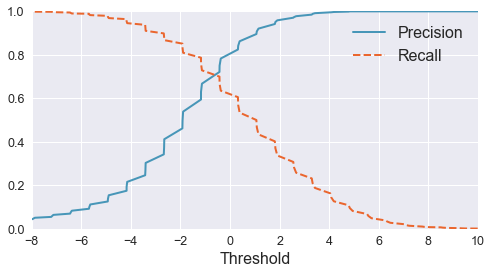

In [31]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-8, 10]);

So, it looks like we could inrease (recall at the expense of precision), by setting the threshold closer to -1.85. This would result in a recall closer to 80% with a Precision around 60%. Lets give that a shot:

In [32]:
print(classification_report(label_train, log_reg_pages.decision_function(feat_train_pages) > -1.85))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99    243830
          1       0.59      0.79      0.68      8205

avg / total       0.98      0.98      0.98    252035



Just as we expected. We were able to increase recall by adjusting the threshold while satisfying the precision constraint. Before we move on to the next model, let's try to interpret the output:

### Now let's try to add a second feature. 

Specifically, age to see if this would increase model accuracy.

In [33]:
feat_train_2 = train_set.loc[:,['pages_visited', 'age']].values

log_reg_2 = LogisticRegression()
log_reg_2.fit(feat_train_2, label_train);

In [34]:
print(log_reg_2.score(feat_train_2, label_train))

0.983454678914


In [35]:
print(classification_report(label_train, log_reg_2.predict(feat_train_2)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    243830
          1       0.83      0.62      0.71      8205

avg / total       0.98      0.98      0.98    252035



Looks like adding the age didn't change things much. It did increase precision, recall, and f1-score by 0.01 across the board. But this is not much better. 

Again, let's visualize the model:

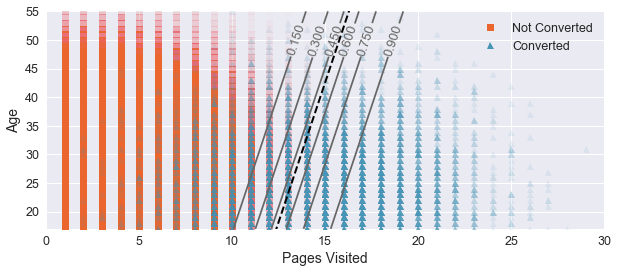

In [36]:
visualize_2d_logreg(log_reg_2, [0, 30], [17, 55], feat_train_2, label_train, manual_locations)

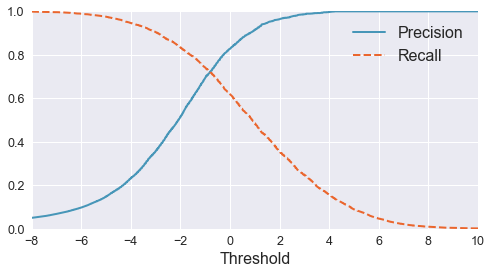

In [37]:
label_scores = cross_val_predict(log_reg_2, feat_train_2, label_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(label_train, label_scores)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-8, 10]);

In [38]:
print(classification_report(label_train, log_reg_2.decision_function(feat_train_2) > -1.5))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99    243830
          1       0.60      0.79      0.69      8205

avg / total       0.98      0.98      0.98    252035



### Now let's try to add a third feature:

Namely: New user

In [39]:
feat_train_3 = train_set.loc[:,['pages_visited', 'age', 'new_user']].values

log_reg_3 = LogisticRegression()
log_reg_3.fit(feat_train_3, label_train);

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
print(log_reg_3.score(feat_train_3, label_train))

0.985057630885


In [41]:
print(classification_report(label_train, log_reg_3.predict(feat_train_3)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    243830
          1       0.84      0.66      0.74      8205

avg / total       0.98      0.99      0.98    252035



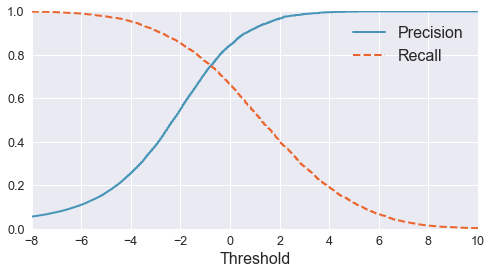

In [42]:
label_scores = cross_val_predict(log_reg_3, feat_train_3, label_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(label_train, label_scores)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-8, 10]);

In [43]:
print(classification_report(label_train, log_reg_3.decision_function(feat_train_3) > -1.75))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99    243830
          1       0.60      0.83      0.69      8205

avg / total       0.98      0.98      0.98    252035



### Now let's try to add a fourth categorical feature:

Namely: New user and then country

In [44]:
feat_list_4 = ['pages_visited', 'age', 'new_user', 'is_China', 'is_Germany', 'is_UK', 'is_US']
feat_train_4 = pd.get_dummies(train_set, prefix='is').loc[:, feat_list_4].values

log_reg_4 = LogisticRegression()
log_reg_4.fit(feat_train_4, label_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
print(log_reg_4.score(feat_train_4, label_train))

0.986148749182


In [46]:
print(classification_report(label_train, log_reg_4.predict(feat_train_4)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    243830
          1       0.85      0.69      0.77      8205

avg / total       0.99      0.99      0.99    252035



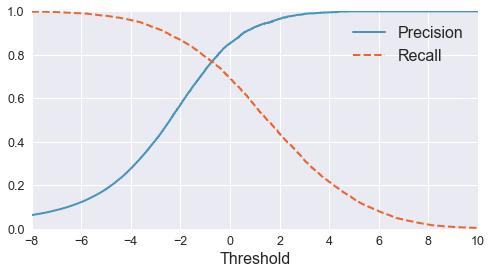

In [47]:
label_scores = cross_val_predict(log_reg_4, feat_train_4, label_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(label_train, label_scores)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-8, 10]);

In [48]:
print(classification_report(label_train, log_reg_4.decision_function(feat_train_4) > -1.85))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99    243830
          1       0.60      0.86      0.71      8205

avg / total       0.98      0.98      0.98    252035



#### There are functions that will be used in the notebook. Make sure these are defined before you try to run anything else

In [1]:
def get_1d_logreg_decn_bndry(feat_range, proba):
    return feat_range[proba[:, 1] >= 0.5][0]

def plt_1d_logreg_proba(ax, feat_range, proba, labels):
    ax.plot(feat_range, proba[:, 1], '-',  lw=2, color='#4796B8', label=labels[0])
    ax.plot(feat_range, proba[:, 0], '--', lw=2, color='#EA662E', label=labels[1])

def plt_1d_logreg_obs(ax, feat, label, transparency=0.1):
    ax.plot(feat[label==0], label[label==0], 's', color='#EA662E', alpha=transparency)
    ax.plot(feat[label==1], label[label==1], '^', color='#4796B8', alpha=transparency)

def plt_1d_logreg_decn_bndry(ax, bndry, feat_range):
    ptp = np.ptp(feat_range)
    dx = 0.03*ptp
    h_len = 0.01*ptp
    ax.plot([bndry, bndry], [0, 1], ':', lw=2, color='#666666')
    ax.text(bndry+dx, 0.48, 'Decision  boundary', fontsize=13, fontweight='bold', color='#666666')
    ax.arrow(bndry, 0.08, -dx, 0, head_width=0.05, head_length=h_len, lw=2, fc='#EA662E', ec='#EA662E')
    ax.arrow(bndry, 0.92,  dx, 0, head_width=0.05, head_length=h_len, lw=2, fc='#4796B8', ec='#4796B8')

def plt_frmt_1d_logreg(ax, feat_range, x_label='feature'):
    ax.set_xlabel(x_label)
    ax.set_ylabel('Probability')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, fancybox=True)
    ax.axis([np.amin(feat_range), np.amax(feat_range), -0.02, 1.02]);

def visualize_1d_logreg(feat_range, proba, labels, transparency, x_label, train_feat, train_label):
    _, ax1 = plt.subplots(figsize=(8, 3))
    bndry = get_1d_logreg_decn_bndry(feat_range, proba)
    plt_1d_logreg_proba(ax1, feat_range, proba, labels)
    plt_1d_logreg_obs(ax1, train_feat, train_label, transparency=transparency)
    plt_1d_logreg_decn_bndry(ax1, bndry, feat_range)
    plt_frmt_1d_logreg(ax1, feat_range, x_label=x_label)

# ---------------------------------------------------------------- #

def get_2d_logreg_feat_space(x0_range, x1_range):
    x0_min, x0_max = x0_range
    x1_min, x1_max = x1_range
    x0, x1 = np.meshgrid(np.linspace(x0_min,  x0_max, 500).reshape(-1, 1),
                         np.linspace(x1_min,  x1_max, 500).reshape(-1, 1))
    return np.c_[x0.ravel(), x1.ravel()], x0, x1

def get_2d_logreg_decn_bndry(log_reg_2, feat_range):
    return -(log_reg_2.coef_[0][0] * np.array(feat_range) + log_reg_2.intercept_[0]) / log_reg_2.coef_[0][1]

def plt_2d_logreg_obs(ax, feat, label):
    ax.plot(feat[label==0, 0], feat[label==0, 1], 's',
         color='#EA662E', markersize=7, alpha=0.002, zorder=1, label='Not Converted')
    
    ax.plot(feat[label==1, 0], feat[label==1, 1], '^',
         color='#4796B8', markersize=7, alpha=0.1, zorder=2, label='Converted')

def plt_2d_logreg_proba(ax, x0, x1, proba, manual_locations):
    surface = proba[:, 1].reshape(x0.shape)
    contour = ax.contour(x0, x1, surface, colors='#666666', zorder=3)
    ax.clabel(contour, inline=1, fontsize=13, manual=manual_locations)

def plt_frmt_2d_logreg(ax, boundary, x0_range, x1_range, x0_label='feature 1', x1_label='feature 2'):
    ax.plot(x0_range, boundary, "k--", linewidth=2)
    plt.xlabel(x0_label, fontsize=14)
    plt.ylabel(x1_label, fontsize=14)
    plt.axis(x0_range + x1_range);
    for lh in ax.legend().legendHandles: 
        lh._legmarker.set_alpha(1)
    
    
def visualize_2d_logreg(log_reg_2, x0_range, x1_range, feat, label, locs):
    _, ax1 = plt.subplots(figsize=(10,4))
    feat_space, x0, x1 = get_2d_logreg_feat_space(x0_range, x1_range)
    bndry = get_2d_logreg_decn_bndry(log_reg_2, x0_range)
    label_proba = log_reg_2.predict_proba(feat_space)
    plt_2d_logreg_obs(ax1, feat, label)
    plt_2d_logreg_proba(ax1, x0, x1, label_proba, locs)
    plt_frmt_2d_logreg(ax1, bndry, x0_range, x1_range, 'Pages Visited', 'Age')

manual_locations = [(13.5, 50), (14.5, 50), (15.5, 50), (16.25, 50), (17.25, 50), (18.65, 50)]

# ---------------------------------------------------------------- #

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], color='#4796B8', label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "--", color='#EA662E', label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(fontsize=16)
    plt.ylim([0, 1])

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, color="#4796B8", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])